In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rasterio
import statsmodels.api as sm

from scipy.special import inv_boxcox
from scipy import stats
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

<Axes: >

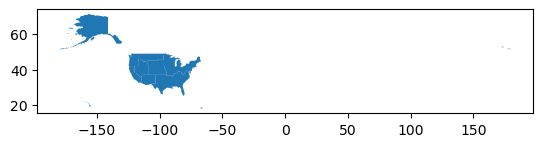

In [9]:
regionsUSFS_shp = gpd.read_file('Shapefiles/S_USA.AdministrativeRegion/S_USA.AdministrativeRegion.shp')
regionsUSFS_shp.plot()

<Axes: >

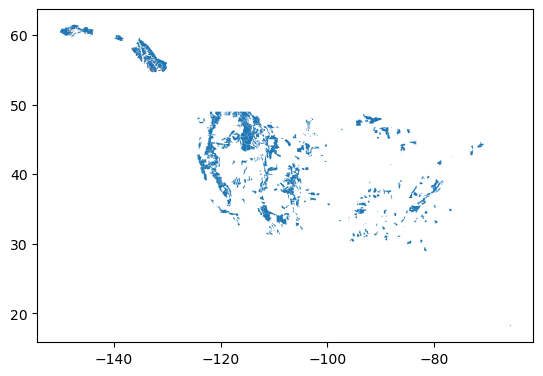

In [10]:
forestsUSFS_shp = gpd.read_file('Shapefiles/S_USA.AdministrativeRegion/S_USA.AdministrativeForest.shp')
forestsUSFS_shp.plot()

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import ProbPlot

In [79]:
timberDf = pd.read_csv('/Users/louisgoodall/Desktop/Timber Data.csv')
cleanCols = ['Year','Quarter','Sold_Volume_MBF','Sold_Volume_CCF',
            'Sold_Value','Sold_per_MBF','Sold_per_CCF','Cut_Volume_MBF',
            'Cut_Volume_CCF','Cut_Value']
for col in cleanCols:
    timberDf[col] = timberDf[col].astype(str).str.replace(',', '', regex=False)
timberDf[cleanCols] = timberDf[cleanCols].astype(float)

df  = timberDf.pivot(index=['National_Forest', 'Year', 'Species', 'Product'], columns='Quarter', values='Sold_Value').reset_index()
# df = df.drop(columns=np.nan)
df.rename(columns={1.0:'Q1', 2.0:'Q2', 3.0:'Q3', 4.0:'Q4'}, inplace=True)
df = df.replace(np.nan, 0)
df = df.assign(Q2 = df['Q2'] - df['Q1'],
               Q3 = df['Q3'] - df['Q2'],
               Q4 = df['Q4'] - df['Q3'])
df[['Q1','Q2','Q3','Q4']] = df[['Q1','Q2','Q3','Q4']].clip(lower=0)
df = df.assign(Total = df['Q2'] + df['Q3'] + df['Q4'] + df['Q1'])
df = pd.melt(df, id_vars=['National_Forest', 'Year', 'Species'], value_vars=['Q1','Q2','Q3','Q4'], value_name='Sold_Value')
df['Year'] = df['Year'].astype(int)
df['Quarter'] = df['Quarter'].astype(str)
df['YearQuarter'] = df['Year'].astype(str) + df['Quarter']
df['Quarter'] = pd.PeriodIndex(df['YearQuarter'], freq='Q').to_timestamp()
df = df.groupby(['National_Forest','Quarter','Species'])[['Sold_Value']].agg('sum').reset_index()
X = df[['Quarter']]
y = df[['Sold_Value']]
X_train, y_train, X_test, y_test = train_test_split(X, y, train_size=0.8, random_state=33)
df['valueDiff'] = df['Sold_Value'].diff()
result = adfuller(df['valueDiff'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -16.529303471338473
p-value: 2.030459995649838e-29


In [81]:
df

,National_Forest,Quarter,Species,Sold_Value,valueDiff
0,Columbia River Gorge,2010-01-01,Douglas-fir,189110.25,NaN
1,Columbia River Gorge,2010-04-01,Douglas-fir,107434.39,-81675.86
2,Columbia River Gorge,2010-07-01,Douglas-fir,0.00,-107434.39
3,Columbia River Gorge,2010-10-01,Douglas-fir,81675.86,81675.86
4,Columbia River Gorge,2011-01-01,Douglas-fir,0.00,-81675.86
...,...,...,...,...,...
2463,Willamette,2013-10-01,Specified Road Charges,0.00,0.00
2464,Willamette,2013-10-01,Sugar Pine,0.00,0.00
2465,Willamette,2013-10-01,Western Hemlock,0.00,0.00
2466,Willamette,2013-10-01,Western Red Cedar,0.00,0.00


In [78]:
# Normal residuals


model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()
plotDf = pd.concat([X, y], axis=1)
normalisedResiduals = model_fit.get_influence().resid_studentized_internal
fittedValues = model_fit.fittedvalues
plot_lm_3 = plt.figure()
plt.scatter(fittedValues, normalisedResiduals, alpha=0.5)
sns.regplot(x=fittedValues, y=normalisedResiduals,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/9b/6_fqcsbn0gj7ftczc3760qlr0000gn/T/ipykernel_59847/2963267410.py:19: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
/var/folders/9b/6_fqcsbn0gj7ftczc3760qlr0000gn/T/ipykernel_59847/2963267410.py:19: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')


TypeError: 1262304000000000000

<Axes: xlabel='Quarter', ylabel='Sold_Value'>

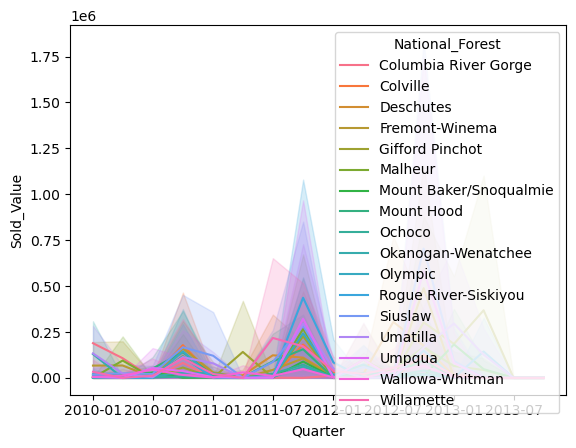

In [73]:
sns.lineplot(df, x='Quarter', y='Sold_Value', hue='National_Forest')

In [75]:
X

,Quarter
0,1262304000000000000
1,1270080000000000000
2,1277942400000000000
3,1285891200000000000
4,1293840000000000000
...,...
2463,1380585600000000000
2464,1380585600000000000
2465,1380585600000000000
2466,1380585600000000000
